## Imports

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

import multiprocessing
from joblib import parallel_backend, Parallel, delayed
from dask.distributed import Client
num_cores = multiprocessing.cpu_count()
client = Client()

import glob
import gc
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras.utils as image

## Plotting

In [33]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_image(data):


    cloud_image, binary_mask = data
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    N = 2

    ax1 = axes[0]
    ax1.set_title('Cloud image')
    im1 = ax1.imshow(cloud_image, cmap='jet')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar1 = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar1.ax.set_ylabel('ADU')

    ax2 = axes[1]
    ax2.set_title('Binary mask')
    im2 = ax2.imshow(binary_mask, cmap=discrete_cmap(N, 'gray'))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im2, cax=cax, orientation='vertical', ticks=range(N))
    cbar.ax.set_yticklabels(['', ''], rotation=90)  # vertically oriented colorbar
    cbar.ax.set_ylabel('0 = Sky         1 = Cloud')

    plt.tight_layout()
    plt.show()

def plot_image_pred(cloud_image, binary_mask, y_pred):

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    N = 2

    ax1 = axes[0]
    ax1.set_title('Cloud image')
    im1 = ax1.imshow(cloud_image, cmap='jet')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar1 = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar1.ax.set_ylabel('ADU')

    ax2 = axes[1]
    ax2.set_title('Binary mask')
    im2 = ax2.imshow(binary_mask, cmap=discrete_cmap(N, 'gray'))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar2 = fig.colorbar(im2, cax=cax, orientation='vertical', ticks=range(N))
    cbar2.ax.set_yticklabels(['', ''], rotation=90)  # vertically oriented colorbar
    cbar2.ax.set_ylabel('0 = Sky         1 = Cloud')

    ax3 = axes[2]
    ax3.set_title('Predicted Binary mask')
    im3 = ax3.imshow(y_pred, cmap='viridis')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar3 = fig.colorbar(im3, cax=cax, orientation='vertical', ticks=range(N))
    cbar3.ax.set_ylabel('0 = Sky         1 = Cloud')

    plt.tight_layout()
    plt.show()


## Download files

In [2]:
!wget 'https://filesender.renater.fr/download.php?token=6263a9b4-1dc1-4eb3-b63f-26582b4221fd&files_ids=28357145' -O MAKED_DATA.zip

--2023-08-26 15:04:49--  https://filesender.renater.fr/download.php?token=6263a9b4-1dc1-4eb3-b63f-26582b4221fd&files_ids=28357145
Resolving filesender.renater.fr (filesender.renater.fr)... 194.57.3.10
Connecting to filesender.renater.fr (filesender.renater.fr)|194.57.3.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 841156647 (802M) [application/gzip]
Saving to: ‘MAKED_DATA.zip’

MAKED_DATA.zip        1%[                    ]  12.01M   466KB/s    eta 30m 10s^C


In [ ]:
!unzip MAKED_DATA.zip

## Createion UNET

In [39]:
input_shape = (512, 640, 1)
output_channels = 1
sigma_noise = 0
channels_list = [128 , 64 , 32 , 32]
#channels_list = [32, 32, 64, 128]

kernel_initializer='glorot_uniform'
#kernel_initializer='he_normal'

def unet():
    unet_input = tf.keras.layers.Input(shape=input_shape)

    list_features = []
    x = unet_input
    for i, n_channels in enumerate(channels_list):
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='relu', kernel_initializer=kernel_initializer, padding='same', name=f'Encoder_conv_{i}')(x)
        #print(f'encoder layer number {i} number of channel {n_channels}')
        list_features.append((n_channels, x))
        x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)


    for i, (n_channels, same_reso_features) in enumerate(reversed(list_features)):
        #print(f'decoder layer number {i} number of channel {n_channels}')
        #print(f'concat decoder layer number {i} number of channel {same_reso_features}')
        x = tf.keras.layers.UpSampling2D(2)(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, same_reso_features])
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='elu', padding='same', kernel_initializer=kernel_initializer, name=f'Decoder_conv_{i}')(x)

    if sigma_noise > 0:
            x = tf.keras.layers.GaussianNoise(sigma_noise)(x)

    unet_output = tf.keras.layers.Conv2D(output_channels, 3, activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(unet_input, unet_output, name='unet')

    return model

In [14]:
gc.collect()

1546

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

model = unet()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Preprocessing

### Data Augmentation

In [86]:
import numpy as np
from scipy import ndimage

def zoom(image, mask, zoom_range=(1, 3)):
    zoom_factor = np.random.uniform(*zoom_range)
    print(zoom_factor)
    new_size = np.round(np.array(image.shape) * zoom_factor).astype(int)
    zoomed_image = ndimage.zoom(image, zoom_factor, order=1)
    zoomed_mask = ndimage.zoom(mask, zoom_factor, order=0)

    # Crop or pad the zoomed image and mask to match the original size
    diff_h = image.shape[0] - new_size[0]
    diff_w = image.shape[1] - new_size[1]
    pad_h = max(-diff_h // 2, 0)
    pad_w = max(-diff_w // 2, 0)
    cropped_image = zoomed_image[pad_h:pad_h+image.shape[0], pad_w:pad_w+image.shape[1]]
    cropped_mask = zoomed_mask[pad_h:pad_h+image.shape[0], pad_w:pad_w+image.shape[1]]

    return cropped_image, cropped_mask

def rotate(image, mask, angle_range=(-45, 45)):
    angle = np.random.uniform(*angle_range)
    rotated_image = ndimage.rotate(image, angle, reshape=False, mode='reflect')
    rotated_mask = ndimage.rotate(mask, angle, reshape=False, mode='reflect')
    return rotated_image, rotated_mask

def shift(image, mask, shift_range=(-200, 200)):
    shift_values = np.random.randint(*shift_range, size=2)
    shifted_image = ndimage.shift(image, shift_values, mode='reflect')
    shifted_mask = ndimage.shift(mask, shift_values, mode='reflect')
    return shifted_image, shifted_mask

def shear(image, mask, shear_range=(-0.2, 0.2)):
    shear_values = np.random.uniform(*shear_range, size=2)
    shear_matrix = np.array([[1, shear_values[0]], [shear_values[1], 1]])
    sheared_image = ndimage.affine_transform(image, shear_matrix, mode='reflect')
    sheared_mask = ndimage.affine_transform(mask, shear_matrix, mode='reflect')
    return sheared_image, sheared_mask

def flip(image, mask):
    flipped_image = np.fliplr(image)
    flipped_mask = np.fliplr(mask)
    return flipped_image, flipped_mask

def random_augmentation(image, mask):
    augmentation_functions = [zoom, rotate, shift, shear, flip]
    chosen_function = np.random.choice(augmentation_functions)
    augmented_image, augmented_mask = chosen_function(image, mask)
    return augmented_image, augmented_mask


<ipython-input-33-83bbdb589386>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


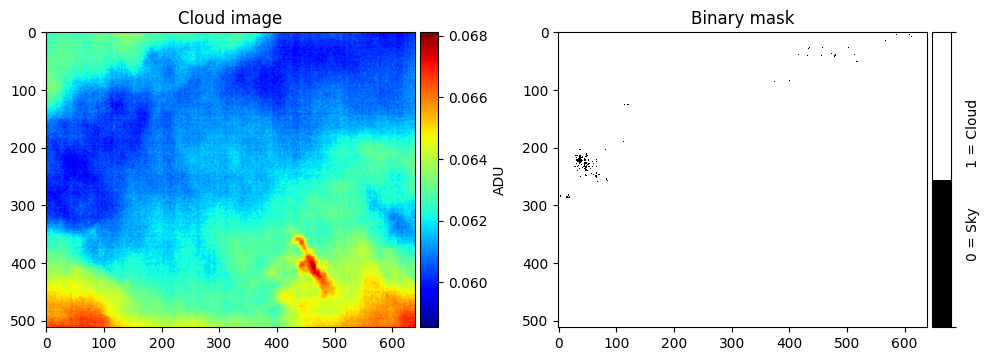

1.7544661314895047


INFO:distributed.utils_perf:full garbage collection released 206.23 MiB from 115416 reference cycles (threshold: 9.54 MiB)


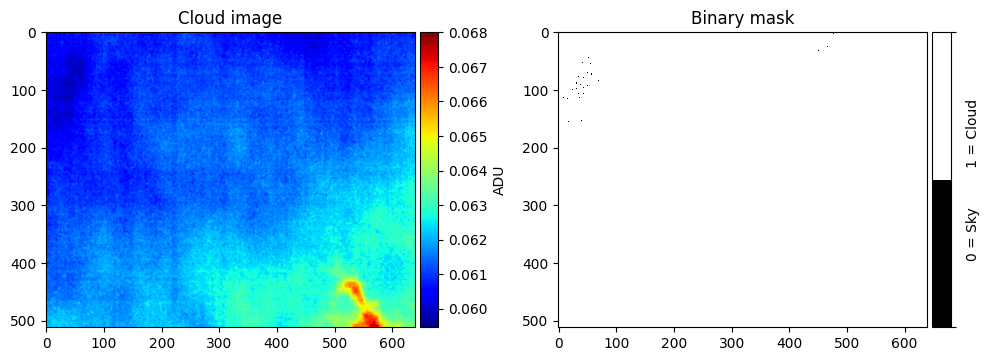

In [87]:
random_index = random.randint(0, len(l_fits) - 1)
data=l_fits[random_index]

plot_image(data=data)

img, mask = data

aug_img = zoom(img, mask)

plot_image(data=aug_img)

### DATA loading

In [88]:
DR = 2**14
def open_fits_with_mask(filename):
    image = fits.open(filename)
    cloud = image[0].data
    mask = image[1].data

    del image

    cloud  = cloud / DR
    return cloud , mask

In [89]:
images_list = glob.glob('/content/MASKED_IMAGES/*.fits')

In [90]:
import random
images_list = random.choices(images_list, k=len(images_list))

In [91]:
with parallel_backend('threading', n_jobs=num_cores):
    l_fits = Parallel(verbose=5)(delayed(open_fits_with_mask)(filename=r) for r in images_list)
l_fits = np.array(l_fits)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 237 out of 237 | elapsed:    1.2s finished


In [92]:
# i miss C++ :(
gc.collect()

INFO:distributed.utils_perf:full garbage collection released 248.13 MiB from 12040 reference cycles (threshold: 9.54 MiB)


12040

<ipython-input-33-83bbdb589386>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


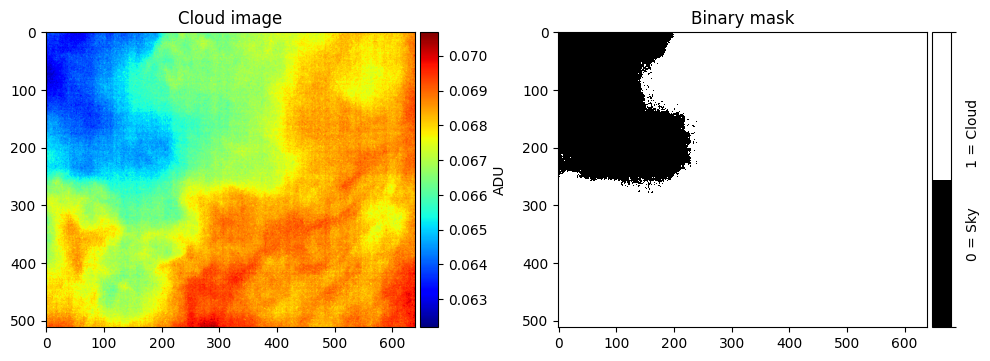

In [93]:
random_index = random.randint(0, len(l_fits) - 1)
plot_image(data=l_fits[random_index])

## DataSet gen and batching

In [94]:
class CloudImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]

        batch_x = self.x_data[batch_indices]
        batch_y = self.y_data[batch_indices]

        # You can perform any preprocessing here before returning the batch

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [95]:
images_cloud = l_fits[:,0]
mask_cloud = l_fits[:,1]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images_cloud, mask_cloud, test_size=0.2, random_state=42)

In [136]:
ds_train_gen = CloudImageDataGenerator(x_data=X_train,y_data=y_train,batch_size=8, shuffle=True)
ds_val_gen = CloudImageDataGenerator(x_data=X_test,y_data=y_test,batch_size=8, shuffle=True)

## Training

In [137]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.01, mode='auto', baseline=None, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10) , verbose=1)

history = model.fit(ds_train_gen,validation_data=ds_val_gen, epochs=100, callbacks=[lr_schedule, early_stopping])
#history = model.fit(images_cloud, mask_cloud, validation_split=0.2, epochs=50, batch_size = 16 , callbacks=[lr_schedule, early_stopping])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
15/15 [==============================] - 23s 1s/step - loss: 0.3435 - accuracy: 0.8783 - val_loss: 0.2190 - val_accuracy: 0.9441 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
15/15 [==============================] - 20s 1s/step - loss: 0.2389 - accuracy: 0.9369 - val_loss: 0.2123 - val_accuracy: 0.9441 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
15/15 [==============================] - 19s 1s/step - loss: 0.2331 - accuracy: 0.9369 - val_loss: 0.2143 - val_accuracy: 0.9441 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
15/15 [==============================] - 19s 1s/step - loss: 0.2362 - accuracy: 0.9369 - val_loss: 0.2197 - val_accuracy: 0.9441 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
15/15 [==============================] - 19s 1s/step

In [ ]:
# Plotting
plt.figure(figsize=(12, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [161]:
# Assuming 'model' is your Keras model
model.save('full_model.h5')

## Plot result

In [160]:
batch_size = 5  # Set the batch size that works for your memory capacity

# Calculate the number of batches
num_batches = len(X_test) // batch_size

# Initialize an empty list to store predictions
all_predictions = []

# Predict using batches
for batch_index in range(num_batches):
    start_index = batch_index * batch_size
    end_index = (batch_index + 1) * batch_size

    batch_X = X_test[start_index:end_index]
    batch_predictions = model.predict(batch_X)
    print(batch_predictions.shape)
    all_predictions.append(batch_predictions)

# If there are any remaining samples not covered by full batches
if len(X_test) % batch_size != 0:
    last_batch_X = X_test[num_batches * batch_size:]
    last_batch_predictions = model.predict(last_batch_X)

    all_predictions.append(last_batch_predictions)

# Combine predictions from all batches
predictions = np.vstack(all_predictions)  # Assuming numpy is imported

Exception ignored in: <function _xla_gc_callback at 0x7d6addd55870>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 [==============================] - 0s 26ms/step
(5, 512, 640, 1)
1/1 [==============================] - 0s 25ms/step
(5, 512, 640, 1)
1/1 [==============================] - 0s 27ms/step
(5, 512, 640, 1)
1/1 [==============================] - 0s 26ms/step
(5, 512, 640, 1)
1/1 [==============================] - 0s 26ms/step
(5, 512, 640, 1)


In [159]:
all_predictions[0].shape

(5, 512, 640, 1)

In [ ]:
batch_predictions = model.predict(X_test)

In [142]:
y_predictions = np.squeeze(predictions, axis=-1)

In [143]:
y_predictions.shape

(30, 512, 640)

<ipython-input-70-83bbdb589386>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


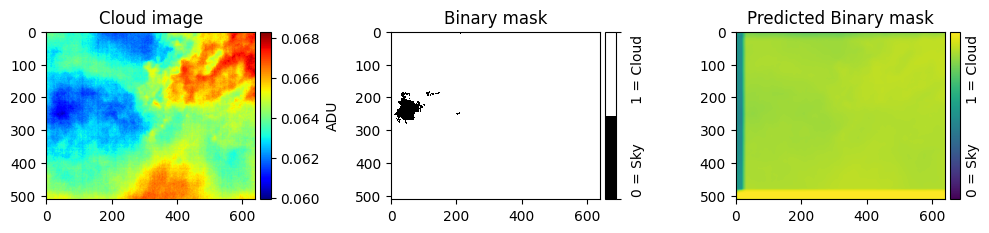

In [144]:
random_index = random.randint(0, len(X_test) - 1)
plot_image_pred(X_test[random_index], y_test[random_index], y_predictions[random_index])

In [124]:
y_test[1]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

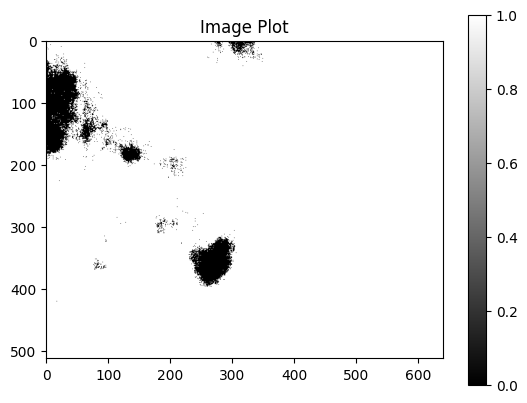

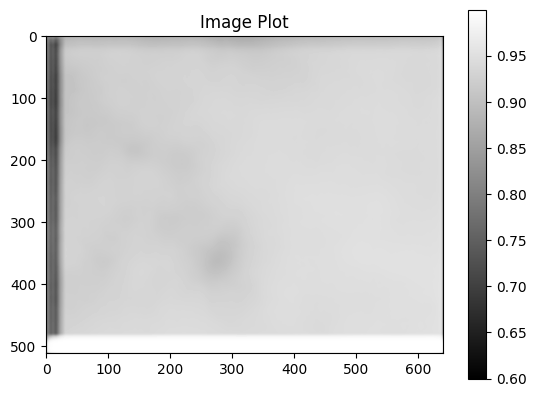

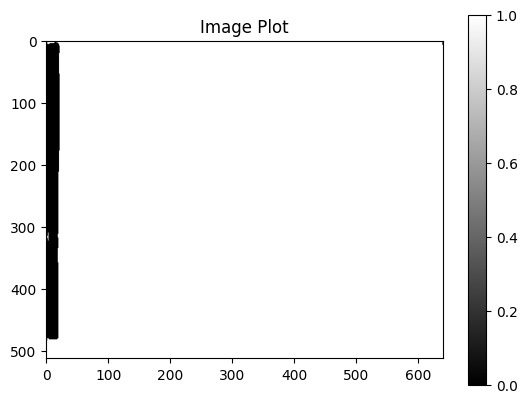

In [151]:
# Create a random NumPy array for demonstration
i = 25
thresh = 0.8
origin = y_predictions[i]
origin_gt = y_test[i]
image_array = np.array(y_predictions[i])

image_array[image_array >= thresh] = 1
image_array[image_array < thresh] = 0

# Plot the NumPy array as an image
plt.imshow(origin_gt, cmap='gray')  # 'gray' colormap for grayscale images
plt.title('Image Plot')
plt.colorbar()  # Display colorbar
plt.show()
# Plot the NumPy array as an image
plt.imshow(origin, cmap='gray')  # 'gray' colormap for grayscale images
plt.title('Image Plot')
plt.colorbar()  # Display colorbar
plt.show()
# Plot the NumPy array as an image
plt.imshow(image_array, cmap='gray')  # 'gray' colormap for grayscale images
plt.title('Image Plot')
plt.colorbar()  # Display colorbar
plt.show()

In [146]:
y_test[29]

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [148]:
y_predictions[29]

array([[0.57967365, 0.62741727, 0.64328414, ..., 0.71536124, 0.6895757 ,
        0.6301998 ],
       [0.61840343, 0.69082654, 0.7145772 , ..., 0.8169495 , 0.7870842 ,
        0.707954  ],
       [0.6300499 , 0.7098818 , 0.7342599 , ..., 0.85469294, 0.8240453 ,
        0.74178267],
       ...,
       [0.8003952 , 0.93011516, 0.9690898 , ..., 0.99548846, 0.9901653 ,
        0.961759  ],
       [0.76246417, 0.89970845, 0.9484872 , ..., 0.9889262 , 0.9792474 ,
        0.936887  ],
       [0.68482864, 0.8131024 , 0.87763184, ..., 0.9540838 , 0.9302904 ,
        0.86223674]], dtype=float32)